<a href="https://colab.research.google.com/github/airpods69/DeepLearningGrind/blob/main/Face_Mask_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Useless Kaggle things
Stuff I need to do to import datasets ;-;

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


In [5]:
!cp kaggle.json /root/.kaggle/

In [6]:
!kaggle datasets download -d andrewmvd/face-mask-detection

 99% 394M/398M [00:01<00:00, 222MB/s]
100% 398M/398M [00:01<00:00, 233MB/s]


In [7]:
!ls

face-mask-detection.zip  kaggle.json  sample_data


In [8]:
!unzip -qq face-mask-detection.zip

## Time to work

In [9]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as rn
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
images = os.path.join('./images/')
annotations = os.path.join('./annotations/')

In [11]:
width = 80
height = 80
img_array = []
labels = []

In [12]:
def dim(obj):

    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)

    return [xmin, ymin, xmax, ymax]

In [13]:
for anot_file in sorted(os.listdir(annotations)):
    file_path = annotations + "/" + anot_file
    xml = ET.parse(file_path)
    root = xml.getroot()
    image = images + "/" + root[1].text

    for bndbox in root.iter('bndbox'):
        [xmin, ymin, xmax, ymax] = dim(bndbox)
        img = cv2.imread(image)
        img_pr = img[ymin:ymax,xmin:xmax]
        img_pr  = cv2.resize(img_pr,(width, height))
        img_array.append(np.array(img_pr))
    for obj in root.findall('object'):
        name = obj.find('name').text 
        labels.append(np.array(name)) 

In [14]:
x = np.array(img_array)
X = x/255

classes = 3
encode = LabelEncoder().fit(labels)
encoded_y = encode.transform(labels)
y = np_utils.to_categorical(encoded_y, classes)
y

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [15]:
X.shape

(4072, 80, 80, 3)

In [16]:
x_train, x_val, y_train, y_val = train_test_split(X,y,
                                                  test_size = 0.33,
                                                  random_state = 42)

In [17]:
model = Sequential()

model.add(Conv2D(filters = 64,
                 kernel_size = (3,3),
                 activation = 'relu',
                 padding = 'same',
                 input_shape = (width, height, 3)
                 ))

model.add(Conv2D(filters = 96,
                 kernel_size = (3,3),
                 activation = 'relu',
                 padding = 'same'
                ))

model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters = 128,
                 kernel_size = (3,3),
                 activation = 'relu',
                 padding = 'same'
                ))

model.add(Conv2D(filters = 128,
                 kernel_size = (3,3),
                 activation = 'relu',
                 padding = 'same'
                ))

model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))

b_size = 80
n_epochs = 20

opt = optimizers.RMSprop(learning_rate = 1e-3)
model.compile(optimizer = opt,
              loss='kullback_leibler_divergence',
              metrics=['accuracy']
              )

In [18]:
datagen = ImageDataGenerator(rescale = 1./255.,
                             validation_split = 0.25,
                             rotation_range = 10,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             zoom_range = 0.2,
                             horizontal_flip = True,
                             brightness_range = [0.2,1.2])

reg = EarlyStopping(monitor = 'val_loss',
                    patience = 2,
                    verbose = 1,
                    min_delta = 0.01)
batch_size = 34

train = model.fit(datagen.flow(x_train,
                             y_train,
                             batch_size = batch_size),
                  steps_per_epoch = x_train.shape[0]//b_size,
                  epochs = n_epochs,
                  validation_data = (x_val, y_val),
                  verbose = 1,
                  callbacks = [reg])

Epoch 1/20
34/34 [==============================] - 16s 136ms/step - loss: 3.3423 - accuracy: 0.7708 - val_loss: 3.3579 - val_accuracy: 0.7917
Epoch 2/20
34/34 [==============================] - 3s 98ms/step - loss: 3.3663 - accuracy: 0.7912 - val_loss: 3.3579 - val_accuracy: 0.7917
Epoch 3/20
34/34 [==============================] - 3s 99ms/step - loss: 3.1951 - accuracy: 0.8018 - val_loss: 3.3579 - val_accuracy: 0.7917
Epoch 3: early stopping


Text(0, 0.5, 'Accuracy')

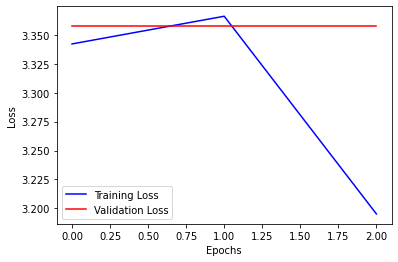

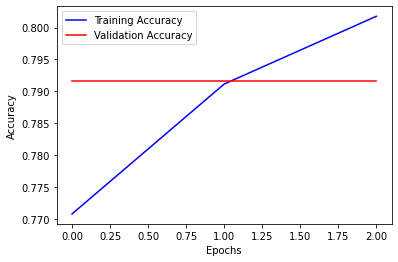

In [20]:
plt.figure()
plt.plot(train.history['loss'], 'blue')
plt.plot(train.history['val_loss'], 'red')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.figure()
plt.plot(train.history['accuracy'], 'blue')
plt.plot(train.history['val_accuracy'], 'red')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')